In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import all Libraries

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import os
import random
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
# Torch Libraries
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as TF

CUDA = torch.cuda.is_available()
print("CUDA :: ", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

CUDA ::  True


# Hyper Parameters

Please edit any and all parameters necessary

In [ ]:
# Network Param
hidden=64; kernel_size=3 ; padding=1

# Dataset Loader
BATCH = 8

image_directory = "./drive/My Drive/Datasets/vRoads_512_small/train/"
gt_directory ="./drive/My Drive/Datasets/vRoads_512_small/train_labels/"

val_image_directory = "./drive/My Drive/Datasets/vRoads_512_small/val/"
val_gt_directory ="./drive/My Drive/Datasets/vRoads_512_small/val_labels/"

test_image_directory = "./drive/My Drive/Datasets/vRoads_512_small/test/"
test_label_directory ="./drive/My Drive/Datasets/vRoads_512_small/test_labels/"

# Training Save PATH
PATH = "./drive/My Drive/Datasets/Models/Road/"
print("Train Path exists : ",os.path.exists(PATH))
PATH += "checkpoint"

# Optimizer
learning_rate=0.01; momentum_opt=0.99

# Train
num_epochs = 700
resume_epoch = 500

# Testing Load Path
TEST_PATH = "./drive/My Drive/Datasets/Models/Assignment_Submission/FCN.tar"

Train Path exists :  True


# Define the FCN Generator Model

In [ ]:
class FCN(nn.Module):
    def __init__(self, model_vgg, hidden = 64, kernel_size = 3, padding = 1, num_classes = 1):
        super(FCN,self).__init__()
        '''
        Initializes the layers for the neral network model. The VGG-16 without Batch Normalization is used
        
        Arguments:
        hidden  --  Number of channels for the first layer. The no of channels for the consequent layers are a multiple of this number
        kernel_size  --  Filter Size for the Conv layers
        padding  --  Padding for the Conv layers. For SAME conv, padding = (kernel_size - 1)/2
        no_of_classes --  The number of output classes
        
        Return:
        None
        '''
        # Split the pretrained model into 4 blocks. Each of them end with a Max Pool
        self.vgg_block0 = nn.Sequential(*list(model_vgg.features)[:14])
        self.vgg_block1 = nn.Sequential(*list(model_vgg.features)[14:24])
        self.vgg_block2 = nn.Sequential(*list(model_vgg.features)[24:34])
        self.vgg_block3 = nn.Sequential(*list(model_vgg.features)[34:])
        # num_classes = 1 due to binary classification
        self.pred1  = nn.Conv2d(4*hidden, num_classes, kernel_size=1)
        self.pred2  = nn.Conv2d(8*hidden, num_classes, kernel_size=1)
        self.pred3 = nn.Conv2d(8*hidden, num_classes, kernel_size=1)

        # Use Upsampling layers to scale up downsampled images. For larger datasets, ConvTranspose2D can be used
        self.up1 = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True)
        self.up2 = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True)
        self.up3 = nn.Upsample(scale_factor=8, mode = 'bilinear', align_corners=True)

    def forward(self, x):
        '''
        Forward propogation of the model. The image is first downsampled and the upsampled
        
        Arguments:
        x  --  Input to the VGG network
        
        Returns
        y  --  Output of the VGG network
        '''
        # Downsample Track
        x_4  = self.vgg_block0(x)      # Process and Downsample by a factor of 4
        x_8  = self.vgg_block1(x_4)    # Process and Downsample by a factor of 2
        x_16 = self.vgg_block2(x_8)    # Process and Downsample by a factor of 2
        x_32 = self.vgg_block3(x_16)   # Process and Downsample by a factor of 2

        # Upsample Track 
        y_16 = self.pred2(x_16) + self.up1(self.pred3(x_32)) # Process and Upsample by a factor of 2
        y_8  = self.up2(y_16) + self.pred1(x_8)              # Process and Upsample by a factor of 2
        y    = self.up3(y_8)                                 # Process and Upsample by a factor of 2
        return y, nn.Sigmoid()(y)                            # Return the Sigmoid output

# Instantiate the Models, Optimizer and Losses

In [ ]:
def dice_coeff(pred, target):
    '''
    Calcualtes the Dice Coefficeint for the 2 specified images

    Arguments:
    pred  --  The predicted image by the neural network
    target  --  The ground truth image/segmented image

    Returns
    coeff.item()  --  The Dice Co-efficient(float) for the predicted image and the ground-truth image 
    '''
    smooth = 1
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten

    intersection = (m1 * m2).sum(1)  # Calculate the Intersection
    coeff = (2. * intersection + smooth) / (m1.sum(1) + m2.sum(1) + smooth)  # Calculate the coeff
    coeff =  torch.mean(coeff)  # Take the mean across the batch
    return coeff.item()  # Return the scalar in float format instead of the tensor format

def IoU(pred, target):
    '''
    Calcualtes the IoU Coefficeint for the 2 specified images

    Arguments:
    pred  --  The predicted image by the neural network
    target  --  The ground truth image/segmented image

    Returns
    iou.item()  --  The IoU Co-efficient(float) for the predicted image and the ground-truth image
    '''
    smooth = 1  # Factor to prevent NaN and maintain smoothness
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten

    intersection = (m1 * m2).sum(1)  # Intersection of the segmented images
    union = m1.sum(1) + m2.sum(1) - intersection  # Union of the Segmented images
    iou = (intersection + smooth) / (union + smooth)  # Calculate the IoU
    iou =  torch.mean(iou)  # Average over the batch
    return iou.item()  # Return the scalar from tensor

def DiceLoss(pred, target):
    '''
    Calcualtes the Dice Loss for the 2 specified images

    Arguments:
    pred  --  The predicted image by the neural network
    target  --  The ground truth image/segmented image

    Returns
    coeff.item()  --  The Dice Loss(tensor) for the predicted image and the ground-truth image 
    '''
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten

    intersection = (m1 * m2).sum()
    loss_value = 1- (2. * intersection + 1.) / (m1.sum() + m2.sum() + 1.)
    return loss_value #  Return the loss for the label and prediction

In [ ]:
# Setup Network
model_vgg = models.vgg16_bn(pretrained = True)
segmentation_model = FCN(model_vgg, hidden=hidden, kernel_size=kernel_size, padding=padding)
segmentation_model.to(device)

# Initialize the Loss functions
# BCE for a glaobal level
# Dice to make sure the loss incorporates the sparseness of the "True" label
criterion_Dice = DiceLoss 
criterion_BCE  = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([100]).to(device))

# Setup optimizer
optimizer = torch.optim.SGD(segmentation_model.parameters(), lr=learning_rate, momentum=momentum_opt, nesterov=True)

# Freeze Layers (Only the 1st as that is the nn.Sequntial block. Hence this effectively freezes all layers in the block)
ct = 0
for child in segmentation_model.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            param.requires_grad = False

# Data Loader class

Define and load the training and validation data

In [ ]:
class SegmentationDatasetLoader(object):
    def __init__(self, img_root_dir, gt_root_dir, train = False):
        '''
        Initialize the Dataloader
        
        Arguments:
        img_root_dir  --  Directory containing the input image files
        gt_root_dir   --  Directory containing the output label files
        train  --  Variable tto differentiate between traning and test/val for data augmentation and transforms
        
        Returns:
        None
        '''
        self.img_root_dir = img_root_dir
        self.gt_root_dir = gt_root_dir
        self.img_files = os.listdir(img_root_dir)
        self.gt_files = os.listdir(gt_root_dir)
        self.gt_files.sort()
        self.img_files.sort()
        self.train = train


    def __getitem__(self, idx):
        '''
        Based on the input index, reads a filen and the corresponding target and outputs both as processed tensors to the net
        
        Arguments:
        idx  --  The index of the dataframe row to be loaded
        
        Returns:
        frame  --  The image tensor of dimension [batch,channels,height,width]
        label  --  The target for the image loaded in a tensor format [batch,1,height,width]
        '''
        # Read the input frame
        frame = Image.open(os.path.join(self.img_root_dir, self.img_files[idx]))
        width, height = frame.size
        # Read the ground-truth and convert to a grayscale format
        gt = Image.open(os.path.join(self.gt_root_dir, self.gt_files[idx]))
        gt = TF.to_grayscale(gt, num_output_channels=1)
        # Transform only for the training phase
        if self.train:
            if random.random() > 0.5:
                # Horizontal Flip
                frame = TF.hflip(frame)
                gt = TF.hflip(gt)
            if random.random() > 0.5:
                # Vertical Flip
                frame = TF.vflip(frame)
                gt = TF.vflip(gt)
            if random.random() > 0.5:
                # Rotation of the image
                angle = random.randint(0, 45)
                frame = TF.rotate(frame, angle)
                gt = TF.rotate(gt, angle)
        return TF.to_tensor(frame), TF.to_tensor(gt)

    def __len__(self):
        '''
        Calculate the number of file/data-points in the directory
        
        Arguments:
        None
        
        Returns:
        Number of files
        '''
        return len(self.img_files)

In [ ]:
# Instantiate the Training DataLoader and Data Iterator
segmentation_dataset = SegmentationDatasetLoader(image_directory, gt_directory, train = True)
segmentation_iter = torch.utils.data.DataLoader(segmentation_dataset, batch_size=BATCH, shuffle=True)
# Instantiate the Validation Data Loader and Data Iterator
val_dataset = SegmentationDatasetLoader(val_image_directory, val_gt_directory)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH)

# Train

In [ ]:
loss_train = []
iterations = len(segmentation_iter)
val_iterations = len(val_iter)
# Resume Epoch Check
if resume_epoch == 0:
    print("Starting Training Loop...")
else:
    checkpoint = torch.load(PATH + str(resume_epoch) + '.tar', map_location=device)
    segmentation_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Resuming Training Loop...")
# Traning Loop
for epoch in range(resume_epoch, num_epochs):
    # Metrics
    loss_epoch = 0
    dice = 0
    dice_val = 0
    iou = 0
    iou_val = 0
    acc_train = 0
    acc_val  = 0 
    # Enable traning
    segmentation_model.train()
    for img, label in tqdm(segmentation_iter):
        img, label = img.to(device), label.to(device)

        # Forward Pass
        optimizer.zero_grad()
        output, output_sigmoid = segmentation_model(img)
        
        # Calculaye loss and metrics
        loss = criterion_Dice(output_sigmoid, label) + criterion_BCE(output, label)
        dice += dice_coeff(output_sigmoid.clone().detach(), label.clone().detach())
        iou  += IoU(output_sigmoid.clone().detach(), label.clone().detach())
        acc_train  += accuracy_score(output_sigmoid.cpu().clone().detach().numpy().ravel()>0.5, label.cpu().clone().detach().numpy().ravel())
        
        # BackProp
        loss_epoch += loss.item()
        loss.backward()
        optimizer.step()
    loss_train.append(loss_epoch)
    print("Epoch : ",epoch + 1, " Loss : ", loss_epoch, " Dice : ", dice/iterations, " IoU : ", iou/iterations)#, " Acc : ", accuracy/iterations)
    # Model Save
    if (epoch+1) % 10 == 0:
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': segmentation_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_epoch}, PATH + str(epoch+1) + '.tar')
    
    # Validation
    segmentation_model.eval()
    with torch.no_grad():
        for img_val, label_val in val_iter:
            img_val, label_val = img_val.to(device), label_val.to(device)
            output_val, output_val_sigmoid = segmentation_model(img_val)
            dice_val += dice_coeff(output_val_sigmoid.clone().detach(), label_val.clone().detach())
            iou_val  += IoU(output_val_sigmoid.clone().detach(), label_val.clone().detach())
            acc_val += accuracy_score(output_val_sigmoid.cpu().clone().detach().numpy().ravel()>0.5, label_val.cpu().clone().detach().numpy().ravel())
    print("Validation Dice : ", dice_val/val_iterations, " IoU : ", iou_val/val_iterations)#, " Acc : ", acc_val/val_iterations)

Resuming Training Loop...



Epoch :  501  Loss :  11.760844320058823  Dice :  0.66750004529953  IoU :  0.5232461476325989
Validation Dice :  0.5774566020284381  IoU :  0.4135946674006326



Epoch :  502  Loss :  11.689794540405273  Dice :  0.6651361274719239  IoU :  0.522690920829773
Validation Dice :  0.5804809672491891  IoU :  0.4166412992136819



Epoch :  503  Loss :  11.849695295095444  Dice :  0.6508112072944641  IoU :  0.5075919139385223
Validation Dice :  0.5804404446056911  IoU :  0.4165727453572409



Epoch :  504  Loss :  11.653764069080353  Dice :  0.6626157188415527  IoU :  0.5197956466674805
Validation Dice :  0.5779865213802883  IoU :  0.4139940142631531



Epoch :  505  Loss :  11.60541108250618  Dice :  0.6648090839385986  IoU :  0.5219647359848022
Validation Dice :  0.5791981901441302  IoU :  0.4153356807572501



Epoch :  506  Loss :  11.738329350948334  Dice :  0.6557917594909668  IoU :  0.5115841233730316
Validation Dice :  0.5800979903766087  IoU :  0.41669364486421856



Epoch :  507  Loss :  11.785800069570541  Dice :  0.6632965445518494  IoU :  0.5206984901428222
Validation Dice :  0.580004164150783  IoU :  0.4164254495075771



Epoch :  508  Loss :  11.479666262865067  Dice :  0.6679535365104675  IoU :  0.5255756986141205
Validation Dice :  0.581759546484266  IoU :  0.4181315175124577



Epoch :  509  Loss :  11.813145637512207  Dice :  0.6754238224029541  IoU :  0.5311387693881988
Validation Dice :  0.5830742291041783  IoU :  0.4194846877029964



Epoch :  510  Loss :  11.762993961572647  Dice :  0.6631361484527588  IoU :  0.5203594529628753
Validation Dice :  0.5813765440668378  IoU :  0.4177776106766292



Epoch :  511  Loss :  11.906082302331924  Dice :  0.6685002756118774  IoU :  0.5243185043334961
Validation Dice :  0.576495281287602  IoU :  0.4123931867735727



Epoch :  512  Loss :  12.072578579187393  Dice :  0.6749056363105774  IoU :  0.5306834423542023
Validation Dice :  0.5785386647496905  IoU :  0.4148613427366529



Epoch :  513  Loss :  11.965185940265656  Dice :  0.6577440345287323  IoU :  0.5146633744239807
Validation Dice :  0.5811602004936763  IoU :  0.41783357518059866



Epoch :  514  Loss :  11.669718027114868  Dice :  0.6737885689735412  IoU :  0.5296645748615265
Validation Dice :  0.5816511682101658  IoU :  0.41858733551842825



Epoch :  515  Loss :  11.817112863063812  Dice :  0.6600095725059509  IoU :  0.5167093276977539
Validation Dice :  0.5803201794624329  IoU :  0.4170294531754085



Epoch :  516  Loss :  11.603569269180298  Dice :  0.6557883286476135  IoU :  0.5123945164680481
Validation Dice :  0.5787166357040405  IoU :  0.41536728399140493



Epoch :  517  Loss :  11.762949019670486  Dice :  0.6613915491104126  IoU :  0.5185332131385804
Validation Dice :  0.5804561717169625  IoU :  0.4170817903109959



Epoch :  518  Loss :  11.769896298646927  Dice :  0.6673900592327118  IoU :  0.5233919107913971
Validation Dice :  0.5829641222953796  IoU :  0.41923886963299345



Epoch :  519  Loss :  11.811766982078552  Dice :  0.6578089594841003  IoU :  0.514696123600006
Validation Dice :  0.5825345090457371  IoU :  0.41901301060404095



Epoch :  520  Loss :  11.521988213062286  Dice :  0.6653921794891358  IoU :  0.5224706244468689
Validation Dice :  0.5781180092266628  IoU :  0.4147634208202362



Epoch :  521  Loss :  11.794266492128372  Dice :  0.6674933338165283  IoU :  0.5235565602779388
Validation Dice :  0.5781503234590802  IoU :  0.41449403762817383



Epoch :  522  Loss :  11.774498164653778  Dice :  0.6562924027442932  IoU :  0.5128283476829529
Validation Dice :  0.5770650378295353  IoU :  0.4134188847882407



Epoch :  523  Loss :  11.610663712024689  Dice :  0.670053424835205  IoU :  0.5265815198421478
Validation Dice :  0.5804559332983834  IoU :  0.41678470373153687



Epoch :  524  Loss :  11.707699477672577  Dice :  0.6795217800140381  IoU :  0.5363734090328216
Validation Dice :  0.583275318145752  IoU :  0.41978257043021067



Epoch :  525  Loss :  11.593508183956146  Dice :  0.6675706052780152  IoU :  0.5246210694313049
Validation Dice :  0.5838638203484672  IoU :  0.4199932813644409



Epoch :  526  Loss :  11.646100640296936  Dice :  0.6695124626159668  IoU :  0.5269709551334381
Validation Dice :  0.5842340333121163  IoU :  0.4204906863825662



Epoch :  527  Loss :  11.696334958076477  Dice :  0.651118540763855  IoU :  0.5092157781124115
Validation Dice :  0.5806084615843636  IoU :  0.4167702581201281



Epoch :  528  Loss :  11.361613929271698  Dice :  0.6772434449195862  IoU :  0.5360829401016235
Validation Dice :  0.5794710261481149  IoU :  0.41554148708071026



Epoch :  529  Loss :  11.678542375564575  Dice :  0.6596706819534301  IoU :  0.516650265455246
Validation Dice :  0.5796908395630973  IoU :  0.41553987349782673



Epoch :  530  Loss :  11.727909505367279  Dice :  0.6736798453330993  IoU :  0.5305351412296295
Validation Dice :  0.5850181409290859  IoU :  0.4210703798702785



Epoch :  531  Loss :  11.517271399497986  Dice :  0.676597671508789  IoU :  0.5344470846652984
Validation Dice :  0.5878843494824001  IoU :  0.4240272726331438



Epoch :  532  Loss :  11.55743733048439  Dice :  0.6914059829711914  IoU :  0.5492689299583435
Validation Dice :  0.5846209526062012  IoU :  0.42050012946128845



Epoch :  533  Loss :  11.586375147104263  Dice :  0.6703452897071839  IoU :  0.527953358888626
Validation Dice :  0.5850058538573129  IoU :  0.4212940377848489



Epoch :  534  Loss :  11.45425209403038  Dice :  0.6574329924583435  IoU :  0.5150098931789399
Validation Dice :  0.5810604010309491  IoU :  0.41759256379944937



Epoch :  535  Loss :  11.745496720075607  Dice :  0.656043508052826  IoU :  0.5124061226844787
Validation Dice :  0.5819649526051113  IoU :  0.4187481233051845



Epoch :  536  Loss :  11.486241042613983  Dice :  0.6658473610877991  IoU :  0.5225395011901856
Validation Dice :  0.5826821412358966  IoU :  0.41979383145059856



Epoch :  537  Loss :  11.494085878133774  Dice :  0.665307879447937  IoU :  0.5235874450206757
Validation Dice :  0.5847454156194415  IoU :  0.4215320178440639



Epoch :  538  Loss :  11.412819117307663  Dice :  0.6635832607746124  IoU :  0.5213027966022491
Validation Dice :  0.5858286704335894  IoU :  0.42222651839256287



Epoch :  539  Loss :  11.556343227624893  Dice :  0.6809980869293213  IoU :  0.5381266248226165
Validation Dice :  0.5860227772167751  IoU :  0.4225497714110783



Epoch :  540  Loss :  11.565259426832199  Dice :  0.6694172358512879  IoU :  0.527605550289154
Validation Dice :  0.5832190087863377  IoU :  0.4197804161480495



Epoch :  541  Loss :  11.344227075576782  Dice :  0.6856934189796448  IoU :  0.543431795835495
Validation Dice :  0.5836489711488996  IoU :  0.42036556346075876



Epoch :  542  Loss :  11.475913166999817  Dice :  0.6587627673149109  IoU :  0.5174565744400025
Validation Dice :  0.5826164654323033  IoU :  0.4188773248876844



Epoch :  543  Loss :  11.662211149930954  Dice :  0.6633850955963134  IoU :  0.5206017911434173
Validation Dice :  0.5819341284888131  IoU :  0.4181526856763022



Epoch :  544  Loss :  11.629257589578629  Dice :  0.6674607491493225  IoU :  0.5237240445613861
Validation Dice :  0.5820314543587821  IoU :  0.4181908369064331



Epoch :  545  Loss :  11.67299672961235  Dice :  0.6623469972610474  IoU :  0.5206384921073913
Validation Dice :  0.5808050377028329  IoU :  0.41730452861104694



Epoch :  546  Loss :  11.696816772222519  Dice :  0.6703252196311951  IoU :  0.527955150604248
Validation Dice :  0.5801873632839748  IoU :  0.41647461482456755



Epoch :  547  Loss :  11.852211713790894  Dice :  0.6515308833122253  IoU :  0.508400307893753
Validation Dice :  0.5831473469734192  IoU :  0.4194409166063581



Epoch :  548  Loss :  11.495677381753922  Dice :  0.6727032542228699  IoU :  0.5315887057781219
Validation Dice :  0.5850715296609061  IoU :  0.4214481753962381



Epoch :  549  Loss :  11.51012808084488  Dice :  0.6706642079353332  IoU :  0.528428258895874
Validation Dice :  0.5821847660200936  IoU :  0.4183776761804308



Epoch :  550  Loss :  11.481619536876678  Dice :  0.6804531836509704  IoU :  0.5391691195964813
Validation Dice :  0.5800535380840302  IoU :  0.4168044626712799



Epoch :  551  Loss :  11.4865220785141  Dice :  0.6840503907203674  IoU :  0.5413746643066406
Validation Dice :  0.5777802126748222  IoU :  0.4138904809951782



Epoch :  552  Loss :  11.379716604948044  Dice :  0.6786244213581085  IoU :  0.5367483079433442
Validation Dice :  0.5774364428860801  IoU :  0.4135830615247999



Epoch :  553  Loss :  11.645464181900024  Dice :  0.6725682437419891  IoU :  0.5299651503562928
Validation Dice :  0.5822681699480329  IoU :  0.4187456965446472



Epoch :  554  Loss :  11.565697014331818  Dice :  0.6767166972160339  IoU :  0.5344655096530915
Validation Dice :  0.5860123208590916  IoU :  0.4225436108452933



Epoch :  555  Loss :  11.7422194480896  Dice :  0.6766253614425659  IoU :  0.5333861088752747
Validation Dice :  0.5865184835025242  IoU :  0.4226394423416683



Epoch :  556  Loss :  11.426500648260117  Dice :  0.6633537888526917  IoU :  0.5213238048553467
Validation Dice :  0.585581932749067  IoU :  0.421713616166796



Epoch :  557  Loss :  11.637062847614288  Dice :  0.656959536075592  IoU :  0.5147947645187378
Validation Dice :  0.5854441353252956  IoU :  0.4217343287808554



Epoch :  558  Loss :  11.635539472103119  Dice :  0.6780075526237488  IoU :  0.5347437989711762
Validation Dice :  0.5875111392566136  IoU :  0.423823071377618



Epoch :  559  Loss :  11.619871199131012  Dice :  0.6615947461128235  IoU :  0.519946221113205
Validation Dice :  0.585678654057639  IoU :  0.42198034269469126



Epoch :  560  Loss :  11.375685065984726  Dice :  0.6804024243354797  IoU :  0.5386647748947143
Validation Dice :  0.5809408341135297  IoU :  0.4172017404011318



Epoch :  561  Loss :  11.339825183153152  Dice :  0.6706726861000061  IoU :  0.5286882209777832
Validation Dice :  0.5807076692581177  IoU :  0.41659848179136005



Epoch :  562  Loss :  11.598574012517929  Dice :  0.667701268196106  IoU :  0.5252527046203613
Validation Dice :  0.5858270525932312  IoU :  0.422071818794523



Epoch :  563  Loss :  11.304384350776672  Dice :  0.673356921672821  IoU :  0.531953067779541
Validation Dice :  0.5850986412593296  IoU :  0.42144666825022015



Epoch :  564  Loss :  11.533685177564621  Dice :  0.6790620923042298  IoU :  0.5369124126434326
Validation Dice :  0.5858681372233799  IoU :  0.4219889598233359



Epoch :  565  Loss :  11.275809496641159  Dice :  0.6853538227081298  IoU :  0.5445385456085206
Validation Dice :  0.5850303428513663  IoU :  0.42121222615242004



Epoch :  566  Loss :  11.193605959415436  Dice :  0.6803645515441894  IoU :  0.5388665163516998
Validation Dice :  0.5871104598045349  IoU :  0.4235998136656625



Epoch :  567  Loss :  11.378449708223343  Dice :  0.6847270846366882  IoU :  0.5425337862968445
Validation Dice :  0.5854984947613308  IoU :  0.4221286347934178



Epoch :  568  Loss :  11.318855434656143  Dice :  0.6753848457336425  IoU :  0.5331844639778137
Validation Dice :  0.5835408653531756  IoU :  0.4199801342827933



Epoch :  569  Loss :  11.5489062666893  Dice :  0.6691098380088806  IoU :  0.5266332685947418
Validation Dice :  0.5786096411091941  IoU :  0.41512471437454224



Epoch :  570  Loss :  11.425431430339813  Dice :  0.6487076711654663  IoU :  0.5081089127063751
Validation Dice :  0.5790301050458636  IoU :  0.4156333122934614



Epoch :  571  Loss :  11.447216361761093  Dice :  0.6682575416564941  IoU :  0.5277697706222534
Validation Dice :  0.5809079238346645  IoU :  0.4176830734525408



Epoch :  572  Loss :  11.58424100279808  Dice :  0.6632948684692382  IoU :  0.5223558497428894
Validation Dice :  0.57946229832513  IoU :  0.41609331539699007



Epoch :  573  Loss :  11.310566514730453  Dice :  0.6713975739479064  IoU :  0.529795138835907
Validation Dice :  0.5830727134432111  IoU :  0.4199982157775334



Epoch :  574  Loss :  11.333925813436508  Dice :  0.6779127168655396  IoU :  0.5366415369510651
Validation Dice :  0.5858810203416007  IoU :  0.42282162819589886



Epoch :  575  Loss :  11.322045415639877  Dice :  0.6580722677707672  IoU :  0.5166263425350189
Validation Dice :  0.5820874571800232  IoU :  0.41887898104531424



Epoch :  576  Loss :  11.471470296382904  Dice :  0.6701367616653442  IoU :  0.5288725674152375
Validation Dice :  0.5796887448855809  IoU :  0.41651036058153423



Epoch :  577  Loss :  11.153740286827087  Dice :  0.6744948267936707  IoU :  0.532716691493988
Validation Dice :  0.5826192200183868  IoU :  0.4197180909769876



Epoch :  578  Loss :  11.27224087715149  Dice :  0.6843541407585144  IoU :  0.5432658338546753
Validation Dice :  0.5837951557976859  IoU :  0.42080055815832956



Epoch :  579  Loss :  11.557443261146545  Dice :  0.6717968583106995  IoU :  0.5300945818424225
Validation Dice :  0.5805651800973075  IoU :  0.41734672444207327



Epoch :  580  Loss :  11.305396884679794  Dice :  0.6853954720497132  IoU :  0.5430941033363342
Validation Dice :  0.5798389996801104  IoU :  0.4167068089757647



Epoch :  581  Loss :  11.511474579572678  Dice :  0.6659755444526673  IoU :  0.524675863981247
Validation Dice :  0.5804830959865025  IoU :  0.4180315009185246



Epoch :  582  Loss :  11.328732311725616  Dice :  0.671266930103302  IoU :  0.5304819774627686
Validation Dice :  0.5795287319592067  IoU :  0.4169636496475765



Epoch :  583  Loss :  11.318842887878418  Dice :  0.6749620127677918  IoU :  0.5344233083724975
Validation Dice :  0.58107271364757  IoU :  0.41862939511026653



Epoch :  584  Loss :  11.160121202468872  Dice :  0.6709085130691528  IoU :  0.529839792251587
Validation Dice :  0.5824828956808362  IoU :  0.41964681659426006



Epoch :  585  Loss :  11.52448657155037  Dice :  0.67027827501297  IoU :  0.5280603849887848
Validation Dice :  0.5851767318589347  IoU :  0.42185111556734356



Epoch :  586  Loss :  11.306303024291992  Dice :  0.6926805925369263  IoU :  0.5516759812831878
Validation Dice :  0.5877399274281093  IoU :  0.4245981276035309



Epoch :  587  Loss :  11.323856502771378  Dice :  0.685248475074768  IoU :  0.5437333858013154
Validation Dice :  0.5891717672348022  IoU :  0.4262967194829668



Epoch :  588  Loss :  11.331744372844696  Dice :  0.6778763413429261  IoU :  0.5373959875106812
Validation Dice :  0.5891932589667184  IoU :  0.42622735670634676



Epoch :  589  Loss :  11.354818224906921  Dice :  0.665599615573883  IoU :  0.5248025000095368
Validation Dice :  0.5843421220779419  IoU :  0.4214686325618199



Epoch :  590  Loss :  11.375727325677872  Dice :  0.6818860173225403  IoU :  0.5416328895092011
Validation Dice :  0.5827852828162057  IoU :  0.41976952978542875



Epoch :  591  Loss :  11.403384953737259  Dice :  0.6668672108650208  IoU :  0.5262048041820526
Validation Dice :  0.5838349631854466  IoU :  0.42094020332608906



Epoch :  592  Loss :  11.326776057481766  Dice :  0.6810085153579712  IoU :  0.5389199888706208
Validation Dice :  0.5822264977863857  IoU :  0.41992613673210144



Epoch :  593  Loss :  11.177644222974777  Dice :  0.6780660057067871  IoU :  0.5365114104747772
Validation Dice :  0.5847695469856262  IoU :  0.4220829222883497



Epoch :  594  Loss :  11.327260106801987  Dice :  0.675466935634613  IoU :  0.5339782762527466
Validation Dice :  0.5808767761502948  IoU :  0.4179362314088004



Epoch :  595  Loss :  11.430945426225662  Dice :  0.6815520572662354  IoU :  0.5389585268497467
Validation Dice :  0.5783818193844387  IoU :  0.41529396176338196



Epoch :  596  Loss :  11.176458597183228  Dice :  0.680039336681366  IoU :  0.5394714987277984
Validation Dice :  0.582898314510073  IoU :  0.4203970091683524



Epoch :  597  Loss :  11.245900094509125  Dice :  0.6704590249061585  IoU :  0.5305861818790436
Validation Dice :  0.5789078005722591  IoU :  0.4161771237850189



Epoch :  598  Loss :  11.252573072910309  Dice :  0.6722683370113373  IoU :  0.5313672614097595
Validation Dice :  0.5796092620917729  IoU :  0.4170851537159511



Epoch :  599  Loss :  11.041217625141144  Dice :  0.6733967781066894  IoU :  0.5320684885978699
Validation Dice :  0.580327855689185  IoU :  0.41778875248772757



Epoch :  600  Loss :  11.035959869623184  Dice :  0.6750884079933166  IoU :  0.5345306611061096
Validation Dice :  0.5847204753330776  IoU :  0.4218710107462747



Epoch :  601  Loss :  11.195470750331879  Dice :  0.6792180132865906  IoU :  0.5391650807857513
Validation Dice :  0.5865205100604466  IoU :  0.4235776960849762



Epoch :  602  Loss :  11.143266201019287  Dice :  0.678140664100647  IoU :  0.5390084254741668
Validation Dice :  0.5836643746920994  IoU :  0.42087853380611967



Epoch :  603  Loss :  11.287611812353134  Dice :  0.677244348526001  IoU :  0.5361099994182587
Validation Dice :  0.5830941370555333  IoU :  0.4204834657055991



Epoch :  604  Loss :  11.228713870048523  Dice :  0.6845381498336792  IoU :  0.5440717279911041
Validation Dice :  0.5838963985443115  IoU :  0.4206779897212982



Epoch :  605  Loss :  11.103959381580353  Dice :  0.6858673763275146  IoU :  0.5447871088981628
Validation Dice :  0.5887959173747471  IoU :  0.42573122467313496



Epoch :  606  Loss :  11.066012173891068  Dice :  0.6960626101493835  IoU :  0.5549497854709625
Validation Dice :  0.5894924529961177  IoU :  0.42657543080193655



Epoch :  607  Loss :  11.131566733121872  Dice :  0.6830180191993713  IoU :  0.542916226387024
Validation Dice :  0.5875990561076573  IoU :  0.4246517930712019



Epoch :  608  Loss :  11.065944820642471  Dice :  0.6764846992492676  IoU :  0.5354594755172729
Validation Dice :  0.5862337180546352  IoU :  0.4232672793524606



Epoch :  609  Loss :  11.351083666086197  Dice :  0.6668265867233276  IoU :  0.5250818741321563
Validation Dice :  0.5842047887189048  IoU :  0.4213377663067409



Epoch :  610  Loss :  11.116414487361908  Dice :  0.6804825091361999  IoU :  0.5401289272308349
Validation Dice :  0.5826970849718366  IoU :  0.41964447924069



Epoch :  611  Loss :  11.320168226957321  Dice :  0.6810195899009704  IoU :  0.5396030330657959
Validation Dice :  0.5855700203350612  IoU :  0.42258593440055847



Epoch :  612  Loss :  11.091390371322632  Dice :  0.6652905249595642  IoU :  0.5251743245124817
Validation Dice :  0.5855281863893781  IoU :  0.422606212752206



Epoch :  613  Loss :  11.157838493585587  Dice :  0.6847134757041932  IoU :  0.5451510500907898
Validation Dice :  0.5843608123915536  IoU :  0.4211554229259491



Epoch :  614  Loss :  11.148575961589813  Dice :  0.6993790364265442  IoU :  0.5585160958766937
Validation Dice :  0.5832121627671378  IoU :  0.4204603518758501



Epoch :  615  Loss :  11.042276799678802  Dice :  0.6967056059837341  IoU :  0.5568185174465179
Validation Dice :  0.5839140542915889  IoU :  0.42119856817381723



Epoch :  616  Loss :  11.130431443452835  Dice :  0.6842334246635438  IoU :  0.5437992227077484
Validation Dice :  0.5852121753352029  IoU :  0.42238943917410715



Epoch :  617  Loss :  11.554600894451141  Dice :  0.6843753290176392  IoU :  0.5436859619617462
Validation Dice :  0.5835611394473484  IoU :  0.4209371932915279



Epoch :  618  Loss :  11.115741163492203  Dice :  0.6790481400489807  IoU :  0.5389579701423645
Validation Dice :  0.5833850417818341  IoU :  0.4205970679010664



Epoch :  619  Loss :  11.29057177901268  Dice :  0.6680027985572815  IoU :  0.5275331938266754
Validation Dice :  0.583412012883595  IoU :  0.4209916463920048



Epoch :  620  Loss :  11.128042757511139  Dice :  0.683924629688263  IoU :  0.543653359413147
Validation Dice :  0.5835287570953369  IoU :  0.4214829589639391



Epoch :  621  Loss :  11.22440305352211  Dice :  0.6911127090454101  IoU :  0.5504472875595092
Validation Dice :  0.5851479172706604  IoU :  0.42262391107422964



Epoch :  622  Loss :  10.99946054816246  Dice :  0.6841376543045044  IoU :  0.5438858437538147
Validation Dice :  0.582208684512547  IoU :  0.41902706027030945



Epoch :  623  Loss :  11.33587396144867  Dice :  0.6857650542259216  IoU :  0.545025315284729
Validation Dice :  0.5817080991608756  IoU :  0.41840205022266935



Epoch :  624  Loss :  11.160239905118942  Dice :  0.6704350447654724  IoU :  0.5301157903671264
Validation Dice :  0.5869198611804417  IoU :  0.4236806333065033



Epoch :  625  Loss :  11.099343627691269  Dice :  0.6726302206516266  IoU :  0.5314191734790802
Validation Dice :  0.5908198228904179  IoU :  0.42820960709026884



Epoch :  626  Loss :  11.170455694198608  Dice :  0.6767208886146545  IoU :  0.5355809819698334
Validation Dice :  0.5888820290565491  IoU :  0.42587950825691223



Epoch :  627  Loss :  11.218467742204666  Dice :  0.6893949270248413  IoU :  0.5486624085903168
Validation Dice :  0.5862469332558768  IoU :  0.4228862353733608



Epoch :  628  Loss :  10.94184735417366  Dice :  0.6867279505729675  IoU :  0.5478684365749359
Validation Dice :  0.5869329827172416  IoU :  0.42349628039768766



Epoch :  629  Loss :  11.068581849336624  Dice :  0.694001293182373  IoU :  0.5539117574691772
Validation Dice :  0.5889732582228524  IoU :  0.4257792660168239



Epoch :  630  Loss :  11.037380337715149  Dice :  0.6891942405700684  IoU :  0.5493836450576782
Validation Dice :  0.5883696675300598  IoU :  0.42535708631787983



Epoch :  631  Loss :  11.1037837266922  Dice :  0.6840535163879394  IoU :  0.5441861915588379
Validation Dice :  0.5875868882451739  IoU :  0.4244117225919451



Epoch :  632  Loss :  11.209781467914581  Dice :  0.6761858940124512  IoU :  0.5352249825000763
Validation Dice :  0.584744530064719  IoU :  0.4215513127190726



Epoch :  633  Loss :  11.1964051425457  Dice :  0.6859293675422669  IoU :  0.5454107880592346
Validation Dice :  0.5835040722574506  IoU :  0.4201165054525648



Epoch :  634  Loss :  11.10562252998352  Dice :  0.6840080189704895  IoU :  0.5438712668418885
Validation Dice :  0.5860098259789603  IoU :  0.42304225478853497



Epoch :  635  Loss :  10.898007541894913  Dice :  0.6818838477134704  IoU :  0.5416846287250519
Validation Dice :  0.5895741326468331  IoU :  0.4266769758292607



Epoch :  636  Loss :  10.857277512550354  Dice :  0.6937092971801758  IoU :  0.5536096012592315
Validation Dice :  0.5908377511160714  IoU :  0.42835464647838045



Epoch :  637  Loss :  10.825265973806381  Dice :  0.6707403755187988  IoU :  0.5321607279777527
Validation Dice :  0.5884563667433602  IoU :  0.42548772266932894



Epoch :  638  Loss :  11.040137737989426  Dice :  0.7001281404495239  IoU :  0.5595434844493866
Validation Dice :  0.5884093386786324  IoU :  0.4255668265478952



Epoch :  639  Loss :  10.910481959581375  Dice :  0.6836525201797485  IoU :  0.5435624718666077
Validation Dice :  0.589401866708483  IoU :  0.42674796070371357



Epoch :  640  Loss :  10.861383616924286  Dice :  0.6822433733940124  IoU :  0.54285942196846
Validation Dice :  0.5861500118459974  IoU :  0.4231373199394771



Epoch :  641  Loss :  11.004819303750992  Dice :  0.6976856791973114  IoU :  0.5575986158847809
Validation Dice :  0.5874817882265363  IoU :  0.4244655413287027



Epoch :  642  Loss :  11.070049732923508  Dice :  0.6812434720993042  IoU :  0.5416789996623993
Validation Dice :  0.5887443934168134  IoU :  0.4261274550642286



Epoch :  643  Loss :  10.983286380767822  Dice :  0.6950660610198974  IoU :  0.5553769266605377
Validation Dice :  0.5881302441869464  IoU :  0.42568110142435345



Epoch :  644  Loss :  10.986072063446045  Dice :  0.6950677251815796  IoU :  0.555673030614853
Validation Dice :  0.5879639642579215  IoU :  0.4246297648974827



Epoch :  645  Loss :  10.991118520498276  Dice :  0.6950127863883973  IoU :  0.554517080783844
Validation Dice :  0.5830324377332415  IoU :  0.4196170355592455



Epoch :  646  Loss :  10.954659700393677  Dice :  0.6954940629005432  IoU :  0.5554491674900055
Validation Dice :  0.5871148577758244  IoU :  0.42456951311656405



Epoch :  647  Loss :  10.91469007730484  Dice :  0.692274227142334  IoU :  0.5523319077491761
Validation Dice :  0.5895749798842839  IoU :  0.4272561626774924



Epoch :  648  Loss :  10.975293576717377  Dice :  0.713792872428894  IoU :  0.57393794298172
Validation Dice :  0.5904172318322318  IoU :  0.4275441425187247



Epoch :  649  Loss :  10.853228688240051  Dice :  0.6987134861946106  IoU :  0.5594506633281707
Validation Dice :  0.5898710318974086  IoU :  0.4267557774271284



Epoch :  650  Loss :  11.172173142433167  Dice :  0.68768869638443  IoU :  0.5467736327648163
Validation Dice :  0.5876286114965167  IoU :  0.4243760534695217



Epoch :  651  Loss :  10.87291806936264  Dice :  0.6925652933120727  IoU :  0.5531457352638245
Validation Dice :  0.5859234843935285  IoU :  0.4226548033101218



Epoch :  652  Loss :  10.863328665494919  Dice :  0.6946409845352173  IoU :  0.554476044178009
Validation Dice :  0.5914749503135681  IoU :  0.42836365955216543



Epoch :  653  Loss :  10.936542600393295  Dice :  0.6862432098388672  IoU :  0.5459366738796234
Validation Dice :  0.5884943519319806  IoU :  0.42536690831184387



Epoch :  654  Loss :  11.020428746938705  Dice :  0.6815761828422546  IoU :  0.5422872602939606
Validation Dice :  0.5865544506481716  IoU :  0.4234541058540344



Epoch :  655  Loss :  10.932440638542175  Dice :  0.686628189086914  IoU :  0.5478399825096131
Validation Dice :  0.5882282086781093  IoU :  0.4251569466931479



Epoch :  656  Loss :  10.857190728187561  Dice :  0.6894149041175842  IoU :  0.5506517779827118
Validation Dice :  0.5862740661416735  IoU :  0.4233666147504534



Epoch :  657  Loss :  10.66996082663536  Dice :  0.7022380924224854  IoU :  0.5636040365695953
Validation Dice :  0.5875904389790126  IoU :  0.42465435181345257



Epoch :  658  Loss :  10.890511304140091  Dice :  0.7045193505287171  IoU :  0.5648223686218262
Validation Dice :  0.5885982939175197  IoU :  0.4253127234322684



Epoch :  659  Loss :  10.98397958278656  Dice :  0.6822813129425049  IoU :  0.5424015200138093
Validation Dice :  0.5916641695158822  IoU :  0.428641072341374



Epoch :  660  Loss :  11.077127397060394  Dice :  0.6865007710456849  IoU :  0.5468683385848999
Validation Dice :  0.5878867123808179  IoU :  0.425496369600296



Epoch :  661  Loss :  10.859270125627518  Dice :  0.6692695760726929  IoU :  0.5300310719013214
Validation Dice :  0.5861121501241412  IoU :  0.4237343498638698



Epoch :  662  Loss :  10.852610111236572  Dice :  0.6802115178108216  IoU :  0.541231917142868
Validation Dice :  0.5826755208628518  IoU :  0.4209234629358564



Epoch :  663  Loss :  10.97981944680214  Dice :  0.6738747584819794  IoU :  0.5356991386413574
Validation Dice :  0.5814040473529271  IoU :  0.41928498234067646



Epoch :  664  Loss :  11.03920304775238  Dice :  0.6844795918464661  IoU :  0.5445433223247528
Validation Dice :  0.581145065171378  IoU :  0.41864522865840365



Epoch :  665  Loss :  10.805423527956009  Dice :  0.6965560865402222  IoU :  0.5577455759048462
Validation Dice :  0.5849382366452899  IoU :  0.42175177165440153



Epoch :  666  Loss :  10.938549399375916  Dice :  0.6975947785377502  IoU :  0.557372704744339
Validation Dice :  0.5856285563537053  IoU :  0.4227357804775238



Epoch :  667  Loss :  10.859190285205841  Dice :  0.6886909198760987  IoU :  0.549762351512909
Validation Dice :  0.5828843499932971  IoU :  0.41999804973602295



Epoch :  668  Loss :  10.963249802589417  Dice :  0.6878369283676148  IoU :  0.5493328142166137
Validation Dice :  0.5847831538745335  IoU :  0.4226977229118347



Epoch :  669  Loss :  10.924643844366074  Dice :  0.683100483417511  IoU :  0.5439931082725525
Validation Dice :  0.5839754002434867  IoU :  0.4214497378894261



Epoch :  670  Loss :  10.854431986808777  Dice :  0.6764581871032714  IoU :  0.5389050459861755
Validation Dice :  0.5813235299927848  IoU :  0.41894265583583284



Epoch :  671  Loss :  10.89746829867363  Dice :  0.6942565751075744  IoU :  0.555131367444992
Validation Dice :  0.5846695601940155  IoU :  0.4222441145351955



Epoch :  672  Loss :  10.791619509458542  Dice :  0.6867425751686096  IoU :  0.5468342733383179
Validation Dice :  0.5876417670931134  IoU :  0.4252009987831116



Epoch :  673  Loss :  10.851813793182373  Dice :  0.6877680134773254  IoU :  0.547805905342102
Validation Dice :  0.5867158217089516  IoU :  0.42429241963795256



Epoch :  674  Loss :  10.990514546632767  Dice :  0.6816619873046875  IoU :  0.5416742920875549
Validation Dice :  0.5862683015210288  IoU :  0.4239922208445413



Epoch :  675  Loss :  10.861210346221924  Dice :  0.6866397261619568  IoU :  0.5476806581020355
Validation Dice :  0.5870316113744464  IoU :  0.4245111048221588



Epoch :  676  Loss :  10.685603201389313  Dice :  0.674347767829895  IoU :  0.5351910090446472
Validation Dice :  0.5881338971001762  IoU :  0.42538665873663767



Epoch :  677  Loss :  10.770166337490082  Dice :  0.6856962776184082  IoU :  0.546840969324112
Validation Dice :  0.5883866207940238  IoU :  0.4252212941646576



Epoch :  678  Loss :  10.77739155292511  Dice :  0.7006600666046142  IoU :  0.5611816775798798
Validation Dice :  0.5913992779595512  IoU :  0.4286193251609802



Epoch :  679  Loss :  10.681678295135498  Dice :  0.7086126303672791  IoU :  0.5700392079353332
Validation Dice :  0.591089529650552  IoU :  0.4284569578511374



Epoch :  680  Loss :  10.616359412670135  Dice :  0.7241518592834473  IoU :  0.5865605258941651
Validation Dice :  0.5874287400926862  IoU :  0.424495130777359



Epoch :  681  Loss :  10.604856729507446  Dice :  0.7082878732681275  IoU :  0.569481053352356
Validation Dice :  0.5890366094452995  IoU :  0.42606587069375174



Epoch :  682  Loss :  10.6864133477211  Dice :  0.7005591654777527  IoU :  0.5616963326930999
Validation Dice :  0.5905739494732448  IoU :  0.42757641417639597



Epoch :  683  Loss :  10.771601974964142  Dice :  0.6954284358024597  IoU :  0.5574081826210022
Validation Dice :  0.5909247142927987  IoU :  0.42794404711042133



Epoch :  684  Loss :  10.589196801185608  Dice :  0.7134729170799256  IoU :  0.5754442548751831
Validation Dice :  0.5915396979876927  IoU :  0.42844503692218233



Epoch :  685  Loss :  10.76374638080597  Dice :  0.6975708150863648  IoU :  0.558394364118576
Validation Dice :  0.5916902422904968  IoU :  0.4284621136529105



Epoch :  686  Loss :  10.635934233665466  Dice :  0.7077864480018615  IoU :  0.5689067208766937
Validation Dice :  0.5896983657564435  IoU :  0.42652033482279095



Epoch :  687  Loss :  10.657548248767853  Dice :  0.7011068511009216  IoU :  0.5630824637413024
Validation Dice :  0.589569594178881  IoU :  0.42659888097218107



Epoch :  688  Loss :  10.645102381706238  Dice :  0.7082354950904847  IoU :  0.5695222425460815
Validation Dice :  0.590443709066936  IoU :  0.42746855531420025



Epoch :  689  Loss :  10.641293704509735  Dice :  0.6993687129020691  IoU :  0.5616612720489502
Validation Dice :  0.5908482841082981  IoU :  0.4280782001359122



Epoch :  690  Loss :  10.6761414706707  Dice :  0.7014325714111328  IoU :  0.5640092599391937
Validation Dice :  0.5890288438115802  IoU :  0.42591504539762226



Epoch :  691  Loss :  10.691890686750412  Dice :  0.7028878617286682  IoU :  0.5645662808418274
Validation Dice :  0.5883971963609967  IoU :  0.4249597617558071



Epoch :  692  Loss :  10.936812579631805  Dice :  0.7041446089744567  IoU :  0.5654304468631745
Validation Dice :  0.592880231993539  IoU :  0.4298439068453653



Epoch :  693  Loss :  10.892327904701233  Dice :  0.6901854801177979  IoU :  0.5509526717662812
Validation Dice :  0.5933424489838737  IoU :  0.43024343252182007



Epoch :  694  Loss :  10.54381513595581  Dice :  0.6815890407562256  IoU :  0.5434806966781616
Validation Dice :  0.5916303736822945  IoU :  0.4283390130315508



Epoch :  695  Loss :  10.76785933971405  Dice :  0.6993172264099121  IoU :  0.5613632023334503
Validation Dice :  0.5913701866354261  IoU :  0.42819743497031076



Epoch :  696  Loss :  10.776702016592026  Dice :  0.7044864249229431  IoU :  0.566788694858551
Validation Dice :  0.5885668482099261  IoU :  0.42541182041168213



Epoch :  697  Loss :  10.727027475833893  Dice :  0.7018683981895447  IoU :  0.5625312554836274
Validation Dice :  0.5878803559712001  IoU :  0.4249832587582724



Epoch :  698  Loss :  10.808505415916443  Dice :  0.6972161841392517  IoU :  0.5575057053565979
Validation Dice :  0.5875832268169948  IoU :  0.4249246375901358



Epoch :  699  Loss :  10.750377357006073  Dice :  0.7112888336181641  IoU :  0.5723270106315613
Validation Dice :  0.589994238955634  IoU :  0.4269064111368997



Epoch :  700  Loss :  10.70625525712967  Dice :  0.7188446307182312  IoU :  0.5803823220729828
Validation Dice :  0.5917385731424604  IoU :  0.42849690999303547


# Test

## Define the Test Loader

In [ ]:
loader = SegmentationDatasetLoader(test_image_directory, test_label_directory)
test_iter = torch.utils.data.DataLoader(loader, batch_size=BATCH)

## Run on entire Test set and get the Metrics

In [ ]:
dice_test = 0
iou_test  = 0
cm  = np.zeros((2,2))
test_iterations = len(test_iter)

# Load model state dictionary 
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
segmentation_model.eval()

# Test Loop
with torch.no_grad():
    for img, label in tqdm(test_iter):
        img, label = img.to(device), label.to(device)
        output_test, output_test_sigmoid = segmentation_model(img)
        # Metrics
        dice_test += dice_coeff(output_test_sigmoid.clone().detach(), label.clone().detach())
        iou_test  += IoU(output_test_sigmoid.clone().detach(), label.clone().detach())
        cm += confusion_matrix(output_test_sigmoid.cpu().clone().detach().numpy().ravel()>0.5, label.cpu().clone().detach().numpy().ravel())
tn, fp, fn, tp = cm.ravel()
# Additional metrics for evaluation
acc_seg_test  = (tp+tn)/(tp+tn+fp+fn)
road_seg_test = (tp)/(tp+fn)
back_seg_test = (tn)/(tn+fp)
print("Test Dice : ", dice_test/test_iterations, " IoU : ", iou_test/test_iterations)
print("Accuracy of Segmentation : ", acc_seg_test, " Road : ", road_seg_test, " Background : ", back_seg_test)


Test Dice :  0.49186517412845904  IoU :  0.3678304495719763
Accuracy of Segmentation :  0.9712127304077148  Road :  0.508807205821096  Background :  0.9914104178528517


## Run on an Example

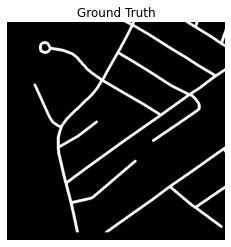

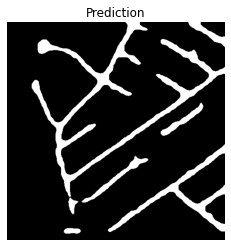

In [ ]:
# Load model state dictionary
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
segmentation_model.eval()

# Morphology Kernels
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
kernel_open = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

# Load Any Image and get the prediction
img , gt = loader.__getitem__(70)

img = img.to(device)
gt = gt.squeeze().numpy()
_, out = segmentation_model(img.unsqueeze(0))

# Morphological Post Processing
pred = out.squeeze().detach().cpu().numpy()>0.5
pred = cv2.morphologyEx((pred).astype(float), cv2.MORPH_CLOSE, kernel_close)
pred = cv2.morphologyEx((pred).astype(float), cv2.MORPH_OPEN, kernel_open)

# Plot GT
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')
plt.show()

# Plot Prediction
plt.imshow(pred, cmap='gray')
plt.title('Prediction')
plt.axis('off')
plt.show()